In [6]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.transform import rotate
from skimage.color import rgb2gray
from skimage.morphology import disk
from skimage.metrics import peak_signal_noise_ratio as PSNR
from scipy import signal


def gaussian_filter(n_rows, n_cols, stdv):
    """
    Returns a 2d Gaussian image filter.
    """
    g_r = signal.windows.gaussian(n_rows, stdv)
    g_c = signal.windows.gaussian(n_cols, stdv)

    G = np.outer(g_r, g_c)

    return G/np.max(G)

plt.gray()

lena= rgb2gray(imread('lena2.tiff'))
frequnoisy = imread('frequnoisy.tif').astype(np.float64)/255

<Figure size 640x480 with 0 Axes>

**Part 2 - Fourier Analysis**

Text(0.5, 1.0, 'Test Image')

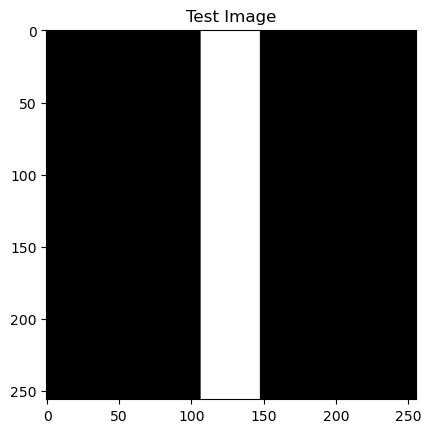

In [7]:
# original test image (vertical white bar on black background)
f = np.zeros((256,256))
f[:,107:148] = 1

plt.figure()
plt.imshow(f)
plt.title('Test Image')


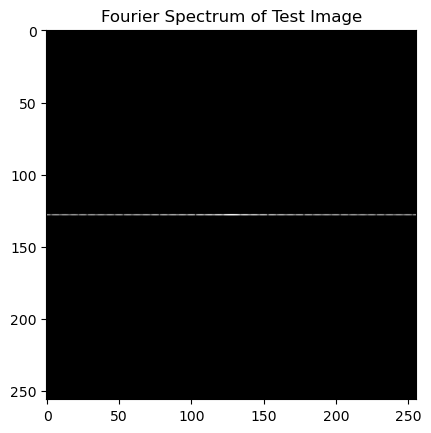

In [8]:
# fourier spectrum of the test image
F = np.fft.fftshift(np.fft.fft2(f))
plt.figure()
plt.imshow(np.log(1+np.abs(F)), cmap='gray')
plt.title('Fourier Spectrum of Test Image')
plt.show()

**1. What can you say about the general distribution of energy in the Fourier spectra? Why?**
It seems that most of the energy is concentrated at the center of the Fourier spectrum. This is because the pixel intensities are mostly constant, with a couple sharp transitions at the edges of the white rectangle. This image contains mostly low frequency components which is represents in the frequency domain with slow and smooth variations.

**2. What characteristics about the test image can you infer from the Fourier spectra?**
The orientation of the rectangle can be predicted since the spectrum is showing horizontal bands, indicating that there are strong horizontal frequency components, as would be seen in a vertical rectangle. The sharpness of the rectangle edges can also be interpreted from the brightness fading away from the center in the Fourier spectrum.

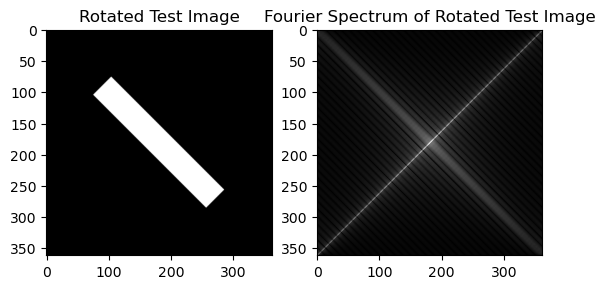

In [9]:
# rotated image fourier spectrum
f_rotated = rotate(f, 45, resize=True)
F_rotated = np.fft.fftshift(np.fft.fft2(f_rotated))

plt.figure()
plt.subplot(1,2,1)
plt.imshow(f_rotated)
plt.title('Rotated Test Image')

plt.subplot(1,2,2)
plt.imshow(np.log(1+np.abs(F_rotated)), cmap='gray')
plt.title('Fourier Spectrum of Rotated Test Image')
plt.show()

**3. How did the Fourier spectra change from the original image (before rotation)?**

When you rotate the test image by 45°, the Fourier spectrum also rotates by the same angle. The energy spectrum is still concentrated at the spectrum, and less concentrated the further you go out. 

The overall shape and energy distribution remain the same — still concentrated near the center (low frequencies) — but the orientation of the high-frequency components (the bright streaks) rotates to match the new angle of the rectangle.

**4. What conclusions and observations can be made about image characteristics based on the Fourier spectra of both original image and the rotated image?**

The orientation of structures in the image directly corresponds to the orientation of patterns in the Fourier spectrum (rotated by the same angle).

The location of energy (centered for low frequencies, spread for edges) stays the same — showing that rotation affects direction, not frequency content magnitude.

The Fourier spectrum is rotation-invariant in magnitude but directionally dependent in spatial orientation — meaning it preserves the same frequency strengths, just rotated in space.

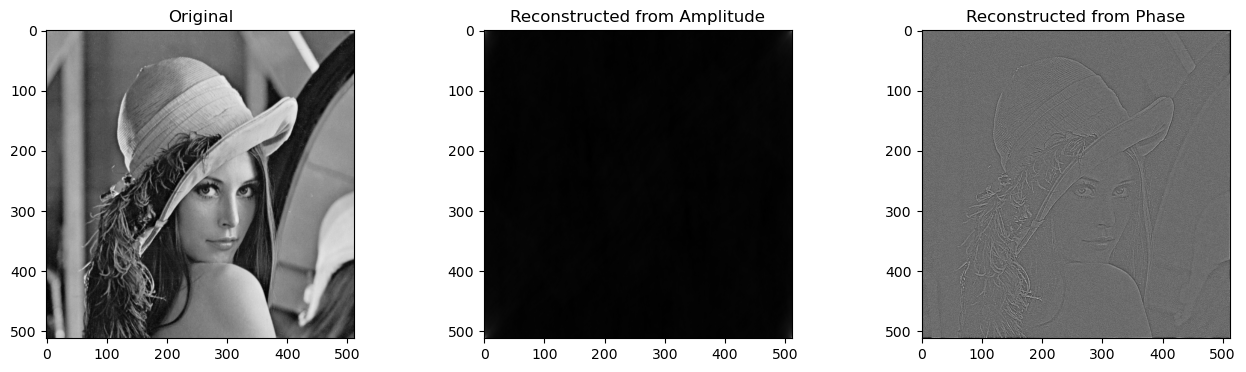

<Figure size 640x480 with 0 Axes>

In [10]:
L = np.fft.fftshift(np.fft.fft2(lena))
A = np.abs(L)
theta = L / A

reconstructed_amp = np.fft.ifft2(np.fft.ifftshift(A)).real
reconstructed_theta = np.fft.ifft2(np.fft.ifftshift(theta)).real

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.imshow(lena)
plt.title('Original')        
plt.subplot(1,3,2)
plt.imshow(reconstructed_amp, cmap='gray')
plt.title('Reconstructed from Amplitude')
plt.subplot(1,3,3)
plt.imshow(reconstructed_theta, cmap='gray')
plt.title('Reconstructed from Phase')
plt.show()
plt.tight_layout()

**5. Describe how the reconstructed image from the amplitude component look like?**
**What image characteristics does the amplitude component capture?**



**6. Describe how the reconstructed image from the phase component look like? What image characteristics does the phase component capture?**
The phase spectrum gives information on the edges in the lena image. The phase component captures the shapes, edges and contours in the image. 